## Case Study - Measuring and Mitigating Bias with Holistic AI Library

The first step to implement bias metrics for regression and classification is to perform a descriptive analysis of the dataset, which helps us identify certain patterns in the dataset and can already provide insights into the information contained in the features.

### Adult Dataset

In this case study, we used the adult data set. This data set is widely used in machine learning exercises and is suitable for applying bias metrics. The data set has categorical features (workclass, education, marital-status, occupation, relationship, race, sex, and native-country) and integer features (age, years of study, capital gain, capital loss, and work hours per week). The prediction task is to determine whether a person makes over 50K a year (a classification task feature).

### Data Description and Exploration

First step is import the libraries that we need. Highlighted the use of [`holisticai`](https://www.holisticai.com/open-source) library, to apply a set of metrics and analysis concern bias.

In [1]:
import sys
sys.path.append('../../')

In [2]:
# import holistic ai 
from holisticai.datasets import load_adult # load adult dataset
from holisticai.bias.plots import group_pie_plot, success_rate_curves, histogram_plot, frequency_plot # import plots

# import data manipulation libraries
import pandas as pd
import numpy as np

# data viz
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
df = load_adult()['frame'] # save dataset as a dataframe 

When describing the continuous data, we can notice that there are 10,000 observations for each variable, in other words, the analysis takes into account 10,000 individuals.

In [3]:
df.describe() # statistical description

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

In the pie chart below, we can observe that this data set has more observations for male than for female. Unbalanced data does not necessarily generate biased results, but it can be a factor that influences bias. We will see these relationships with the results.

In [4]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'class'],
      dtype='object')

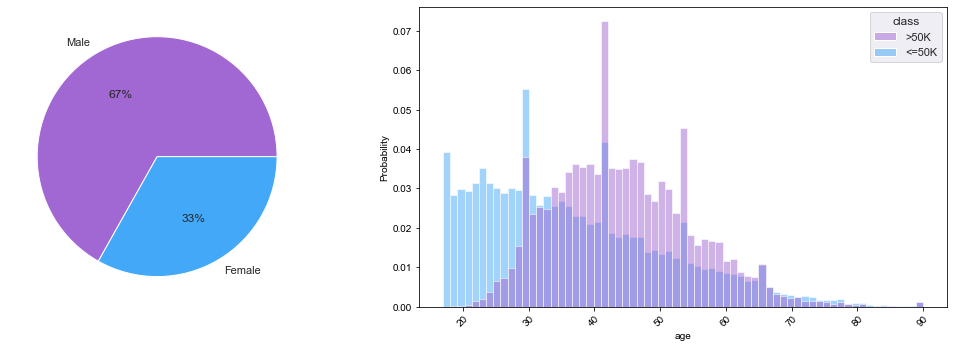

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 1, ncols =2, figsize=(15,5))
group_pie_plot(df['sex'], ax = axes[0])
histogram_plot(df['age'], df['class'], ax = axes[1])
plt.tight_layout()

Two important pieces of information can be observed about this data set. The first point is the imbalance between the number of men and women. The pie chart shows that 67% of the observations in the data set are men, and only 33% are women, meaning that one-third of the data set is related to men. Thus, we have a clear visualization of the participation of men and women in the data set.

On the other hand, the comparison between the age distribution chart for people who earned more or less than 50K per year shows that the average age of those who earned more than 50K is around 44, while the group of people who earned less than 50K has an average age of 36. Therefore, we can say that for the analyzed data set, people who earn more than 50K per year have, on average, a higher age than those who earn less than 50K per year. It is reasonable to imagine that older people have higher incomes associated with their experience.

Observing the graph below, we can notice that there is a higher number of observations for individuals with High-School Grad (HS-grad), bachelors, and some college degree.

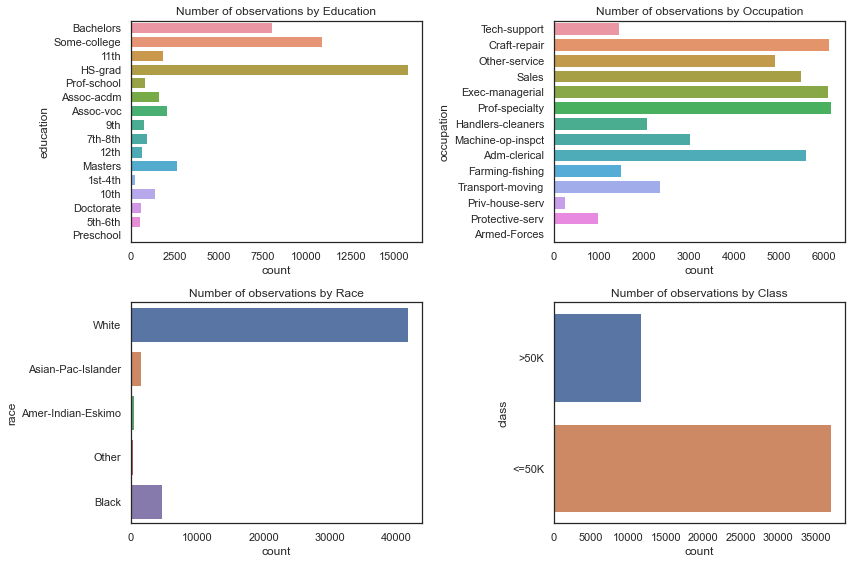

In [7]:
plt.style.use('seaborn-ticks')
fig, axes = plt.subplots(ncols=2, nrows= 2, figsize=(12,8))
sns.countplot(y="education", data=df, ax = axes[0,0]).set_title('Number of observations by Education')
sns.countplot(y="occupation", data=df, ax = axes[0,1]).set_title('Number of observations by Occupation')
sns.countplot(y="race", data=df, ax = axes[1,0]).set_title('Number of observations by Race')
sns.countplot(y="class", data=df, ax = axes[1,1]).set_title('Number of observations by Class')
plt.tight_layout()

### Measuring Bias

#### Pre-processing

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [9]:
df['age'] = df['age'].astype(float)
data = df.apply(LabelEncoder().fit_transform)

In [10]:

drop_elements = ['education', 'native-country', 'class', 'age', 'hours-per-week'] # excluded variables
y = data["class"] # target variable
X = data.drop(drop_elements, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # training data splited 

#### Model Training

In this exercise, we used the classification model Logistic Regression applied to the data set of interest as reference.

In [11]:
# Train a simple linear regression model
LogR = LogisticRegression()
model = LogR.fit(X_train, y_train)

# Predict values
y_pred = model.predict(X_test)

C:\Users\kleyt\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# compute efficacy metrics
from sklearn.metrics import balanced_accuracy_score, f1_score

print('Accuracy: ', balanced_accuracy_score(y_pred, y_test))
print('F1 Score: ', f1_score(y_pred, y_test))

Accuracy:  0.7477053721781413
F1 Score:  0.48522634860395775


#### Bias Metrics

Here, we used the `classification_bias_metrics` function to generate results for four metrics:

- Statistical Parity
- Disparate Impact
- Four Fifths Rule
- Cohen-D
- 2SD Rule

These results can be further analyzed in the [Roadmaps for Risk Mitigations](https://holisticai.gitbook.io/roadmaps-for-risk-mitigation/mitigation-roadmaps/measuring-bias-and-discrimination) prepared by Holistic AI.

In [13]:
from holisticai.bias.metrics import classification_bias_metrics

# male == 1 and female == 0
group_a = np.array(X_test['sex']==1)
group_b = np.array(X_test['sex']==0)
y_pred  = np.array(model.predict(X_test))

classification_bias_metrics(group_a, group_b, y_pred, metric_type='equal_outcome')

Value  Reference
Metric                                  
Statistical Parity   0.124063          0
Disparate Impact     3.263463          1
Four Fifths Rule     0.306423          1
Cohen D              0.365967          0
2SD Rule            16.837744          0

### Mitigating Bias

In [4]:
# Dataframe

from sklearn.model_selection import train_test_split
protected_variables = ["sex", "race"]
output_variable = ["class"]

# Simple preprocessing
y = df[output_variable].replace({">50K": 1, "<=50K": 0})
X = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1))
group = ["sex"]
group_a = df[group] == "Female"
group_b = df[group] == "Male"
data_ = [X, y, group_a, group_b]

# Train test split
dataset = train_test_split(*data_, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]

In [5]:
from holisticai.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from holisticai.bias.metrics import classification_bias_metrics

pipeline = Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('model', LogisticRegression())
    ])

X_train, y_train, group_a, group_b = train_data
pipeline.fit(X_train, y_train)

X_test, y_test, group_a, group_b = train_data
y_pred = pipeline.predict(X_test)

baseline_metric = classification_bias_metrics(group_a, group_b, y_pred, y_test, metric_type='both')

C:\Users\kleyt\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
from holisticai.bias.mitigation import Reweighing
from holisticai.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from holisticai.bias.mitigation import GridSearchReduction

model = GridSearchReduction(constraints="DemographicParity")
model.transform_estimator(LogisticRegression())

pipeline = Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('bm_preprocessing',Reweighing()),
    ('model', LogisticRegression()),
    ])

X_train, y_train, group_a, group_b = train_data
pipeline.fit(X_train, y_train, bm__group_a=group_a, bm__group_b=group_b)

X_test, y_test, group_a, group_b = train_data
y_pred = pipeline.predict(X_test)

bm_pre_metric = classification_bias_metrics(group_a, group_b, y_pred, y_test, metric_type='both')

C:\Users\kleyt\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


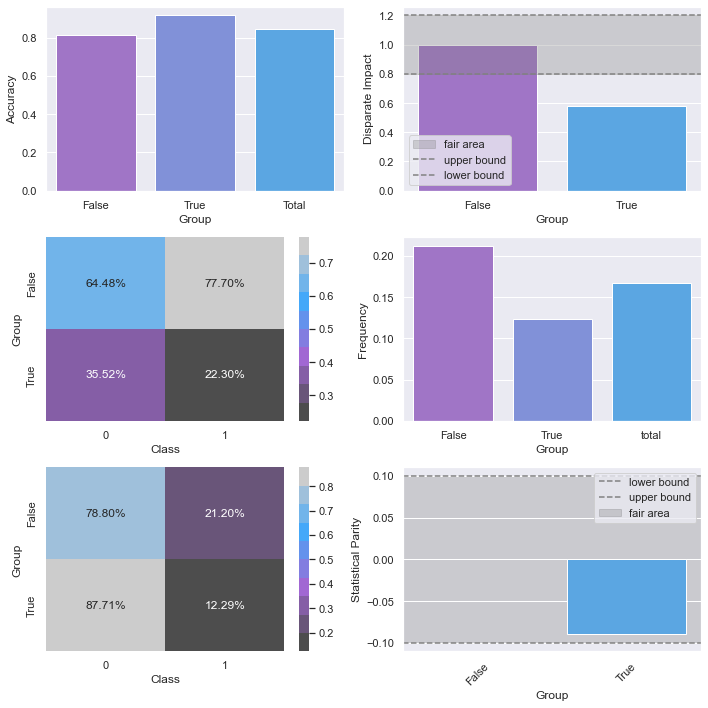

In [15]:
import matplotlib.pyplot as plt
from holisticai.bias.plots import accuracy_bar_plot, disparate_impact_plot, frequency_matrix_plot, frequency_plot,  statistical_parity_plot


fig,axs = plt.subplots(3,2, figsize=(10,10))
accuracy_bar_plot(group_a, y_pred, y_test , ax=axs[0][0])
disparate_impact_plot(group_a, y_pred, ax=axs[0][1])
frequency_matrix_plot(group_a, y_pred, normalize='class', ax=axs[1][0])
frequency_plot(group_a, y_pred, ax = axs[1][1])
frequency_matrix_plot(group_a, y_pred, normalize='group', ax = axs[2][0])
statistical_parity_plot(group_a, y_pred, ax=axs[2][1])
plt.tight_layout()

In [18]:
from holisticai.bias.metrics import classification_bias_metrics
from holisticai.bias.mitigation import GridSearchReduction
from holisticai.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

model = GridSearchReduction(constraints="DemographicParity")
model.transform_estimator(LogisticRegression())

pipeline = Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('bm_inprocessing', model),
    ])

X_train, y_train, group_a, group_b = train_data
pipeline.fit(X_train, y_train, bm__group_a=group_a, bm__group_b=group_b)

X_test, y_test, group_a, group_b = train_data
y_pred = pipeline.predict(X_test)

bm_inp_metric = classification_bias_metrics(group_a, group_b, y_pred, y_test, metric_type='both')

c:\Users\kleyt\AppData\Local\Programs\Python\Python310\lib\site-packages\holisticai\bias\mitigation\inprocessing\commons\classification\_constraints.py:114: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(
c:\Users\kleyt\AppData\Local\Programs\Python\Python310\lib\site-packages\holisticai\bias\mitigation\inprocessing\commons\classification\_constraints.py:114: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(
c:\Users\kleyt\AppData\Local\Programs\Python\Python310\lib\site-packages\holisticai\bias\mitigation\inprocessing\commons\classificat

In [19]:
from holisticai.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from holisticai.bias.mitigation import CalibratedEqualizedOdds

pipeline = Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('model', LogisticRegression()),
    ('bm_postprocessing', CalibratedEqualizedOdds())
    ])

X_train, y_train, group_a, group_b = train_data
pipeline.fit(X_train, y_train, bm__group_a=group_a, bm__group_b=group_b)

X_test, y_test, group_a, group_b = train_data
y_pred = pipeline.predict(X_test,  bm__group_a=group_a, bm__group_b=group_b)

bm_post_metric = classification_bias_metrics(group_a, group_b, y_pred, y_test, metric_type='both')

C:\Users\kleyt\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
df = pd.concat([baseline_metric.iloc[:,0],  bm_pre_metric.iloc[:,0], bm_inp_metric.iloc[:,0], bm_post_metric.iloc[:,:]], axis=1)
df.columns = ['Baseline', 'Reweighing', 'GridSearchReduction','CalibratedEqualizedOdds','Reference']
df

Baseline  Reweighing  \
Metric                                                      
Statistical Parity                  -0.174296   -0.091985   
Disparate Impact                     0.307528    0.568085   
Four Fifths Rule                     0.307528    0.568085   
Cohen D                             -0.450502   -0.239624   
2SD Rule                           -40.982899  -22.142880   
Equality of Opportunity Difference  -0.086721    0.132030   
False Positive Rate Difference      -0.071540   -0.015189   
Average Odds Difference             -0.079130    0.058421   
Accuracy Difference                  0.112037    0.103912   

                                    GridSearchReduction  \
Metric                                                    
Statistical Parity                             0.047368   
Disparate Impact                               1.357229   
Four Fifths Rule                               0.736795   
Cohen D                                        0.133560   
2SD Rule                                      12.395555   
Equality of Opportunity Difference             0.399080   
False Positive Rate Difference                 0.080461   
Average Odds Difference                        0.239771   
Accuracy Difference                            0.088848   

                                    CalibratedEqualizedOdds  Reference  
Metric                                                                  
Statistical Parity                                -0.114535          0  
Disparate Impact                                   0.403279          1  
Four Fifths Rule                                   0.403279          1  
Cohen D                                           -0.320849          0  
2SD Rule                                         -29.502253          0  
Equality of Opportunity Difference                 0.057771          0  
False Positive Rate Difference                    -0.048795          0  
Average Odds Difference                            0.004488          0  
Accuracy Difference                                0.140139          0